# 1. Initial Steps

### Load Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

### Set Default Values

In [2]:
seed = 12 # 12 ears
y = 'OverallPoF' # target

# 2. Data Prep

### Read Data

In [3]:
absorbance = pd.read_csv('Dataset/a_data.csv')
admittance = pd.read_csv('Dataset/y_data.csv')
phase = pd.read_csv('Dataset/p_data.csv')

### Separate Frequencies vs non Frequencies

In [4]:
frequencies = absorbance.filter(regex = r'f[(]').columns
nonf_vars = absorbance.drop(columns = frequencies.union([ y ])).columns

### Add prefixes to frequency columns, so we can merge in the next step

In [5]:
def rename_mapping(columns, prefix):
    mapping = { }
    for c in columns:
        mapping[ c ] = prefix + c
    return mapping 

absorbance = absorbance.rename(columns = rename_mapping(frequencies, 'a_'))
admittance = admittance.rename(columns = rename_mapping(frequencies, 'y_'))
phase = phase.rename(columns = rename_mapping(frequencies, 'p_'))

### Merge Absorbance, Admittance, and Phase

In [6]:
merged_set = absorbance.merge(right = admittance, on = list(nonf_vars) + [ y ])
merged_set = merged_set.merge(right = phase, on = list(nonf_vars) + [ y ])

### 80 : 20 Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    merged_set.drop(columns = y), # X
    merged_set[ y ], # y
    test_size = 0.2, 
    random_state = seed
)

### Feature Scaling

In [8]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

# 3. Modelling

### All (frequency) For One (model)

In [9]:
def performance_report(
    classifier, 
    X_train = X_train, 
    X_test = X_test, 
    y_train = y_train, 
    y_test = y_test,
    top = 10
):
    
    print('Performance on Training Set')
    print(classification_report(y_train, classifier.predict(X_train)))
    print('---------------------------------------------------------')
    
    print('Performance on Testing Set')
    print(classification_report(y_test, classifier.predict(X_test)))
    print('---------------------------------------------------------')
    
    coef_plot = pd.Series(
        data = abs(classifier.coef_[ 0 ]), 
        index = classifier.feature_names_in_
    ).nlargest(top).sort_values().plot(kind = 'barh')
    
    coef_plot.set_title('Top-%s Most Contributing Features'%top)
    coef_plot.set_xlabel('Coefficient Weights')

Performance on Training Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        31

    accuracy                           1.00       191
   macro avg       1.00      1.00      1.00       191
weighted avg       1.00      1.00      1.00       191

---------------------------------------------------------
Performance on Testing Set
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        41
           1       0.50      0.71      0.59         7

    accuracy                           0.85        48
   macro avg       0.72      0.80      0.75        48
weighted avg       0.88      0.85      0.86        48

---------------------------------------------------------


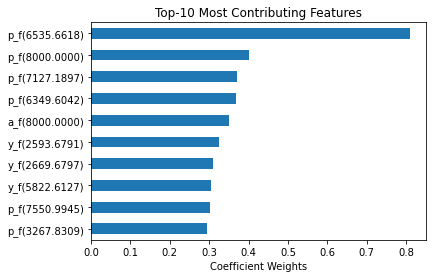

In [10]:
afo_svc = SVC(kernel = 'linear', class_weight = 'balanced', random_state = seed)
afo_svc.fit(X = X_train, y = y_train)

performance_report(classifier = afo_svc)

### AFO with Only Frequencies (OF)

Performance on Training Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        31

    accuracy                           1.00       191
   macro avg       1.00      1.00      1.00       191
weighted avg       1.00      1.00      1.00       191

---------------------------------------------------------
Performance on Testing Set
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        41
           1       0.56      0.71      0.63         7

    accuracy                           0.88        48
   macro avg       0.75      0.81      0.78        48
weighted avg       0.89      0.88      0.88        48

---------------------------------------------------------


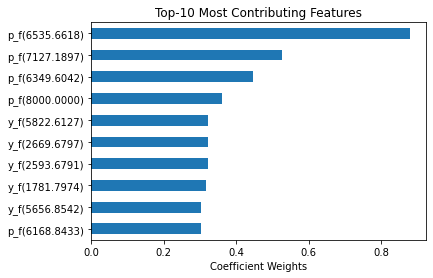

In [11]:
afo_of_svc = SVC(kernel = 'linear', class_weight = 'balanced', random_state = seed)
afo_of_svc.fit(X = X_train.drop(columns = nonf_vars), y = y_train)

performance_report(
    classifier = afo_of_svc,
    X_train = X_train.drop(columns = nonf_vars),
    X_test = X_test.drop(columns = nonf_vars)
)

# *WE DONT USE BEYOND THIS POINT*

### One (model) For All (frequency)

In [12]:
model_storage = [ ]

for freq in frequencies:
    ofa_svc = SVC(kernel = 'linear', class_weight = 'balanced', random_state = seed)
    freq_columns = [ prefix + freq for prefix in [ 'a_', 'y_', 'p_' ] ]
    chosen_col = nonf_vars.append(pd.Index(freq_columns))
    
    ofa_svc.fit(X = X_train[ chosen_col ], y = y_train)
    
    model_storage.append({
        'f(Hz)': float(freq[ freq.find('(') + 1 : freq.find(')') ]),
        'model': ofa_svc,
        'train_f1': f1_score(
            y_true = y_train, 
            y_pred = ofa_svc.predict(X_train[ chosen_col ]),
            average = 'macro'
        ),
        'test_f1': f1_score(
            y_true = y_test, 
            y_pred = ofa_svc.predict(X_test[ chosen_col ]),
            average = 'macro'
        )
    })
    
storage_df = pd.DataFrame(
    model_storage, 
    columns = [ 'f(Hz)', 'model', 'train_f1', 'test_f1' ]
)

In [13]:
storage_df.sort_values(by = [ 'test_f1', 'train_f1' ], ascending = False)

,f(Hz),model,train_f1,test_f1
37,1090.5077,"SVC(class_weight='balanced', kernel='linear', ...",0.835155,0.925000
38,1122.4620,"SVC(class_weight='balanced', kernel='linear', ...",0.828050,0.925000
31,917.0040,"SVC(class_weight='balanced', kernel='linear', ...",0.832397,0.892777
32,943.8743,"SVC(class_weight='balanced', kernel='linear', ...",0.832397,0.892777
34,1000.0000,"SVC(class_weight='balanced', kernel='linear', ...",0.818351,0.892777
...,...,...,...,...
91,5187.3582,"SVC(class_weight='balanced', kernel='linear', ...",0.554686,0.452109
102,7127.1897,"SVC(class_weight='balanced', kernel='linear', ...",0.522381,0.445378
94,5656.8542,"SVC(class_weight='balanced', kernel='linear', ...",0.560024,0.442242
90,5039.6842,"SVC(class_weight='balanced', kernel='linear', ...",0.540374,0.407970


Performance on Training Set
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       160
           1       0.69      0.77      0.73        31

    accuracy                           0.91       191
   macro avg       0.82      0.85      0.84       191
weighted avg       0.91      0.91      0.91       191

---------------------------------------------------------
Performance on Testing Set
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        41
           1       0.78      1.00      0.88         7

    accuracy                           0.96        48
   macro avg       0.89      0.98      0.93        48
weighted avg       0.97      0.96      0.96        48

---------------------------------------------------------


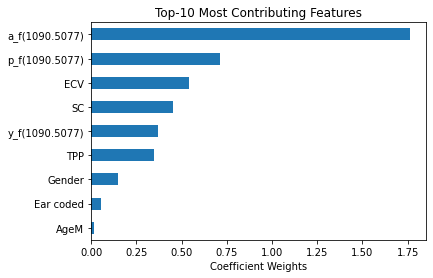

In [14]:
best_idx = 37
best_ofa = storage_df.iloc[ best_idx ][ 'model' ]

performance_report(
    classifier = best_ofa,
    X_train = X_train[ best_ofa.feature_names_in_ ],
    X_test = X_test[ best_ofa.feature_names_in_ ]
)

### OFA with OF

In [15]:
model_storage = [ ]

for freq in frequencies:
    ofa_svc = SVC(kernel = 'linear', class_weight = 'balanced', random_state = seed)
    freq_columns = [ prefix + freq for prefix in [ 'a_', 'y_', 'p_' ] ]
    chosen_col = pd.Index(freq_columns) # only this changed
    
    ofa_svc.fit(X = X_train[ chosen_col ], y = y_train)
    
    model_storage.append({
        'f(Hz)': float(freq[ freq.find('(') + 1 : freq.find(')') ]),
        'model': ofa_svc,
        'train_f1': f1_score(
            y_true = y_train, 
            y_pred = ofa_svc.predict(X_train[ chosen_col ]),
            average = 'macro'
        ),
        'test_f1': f1_score(
            y_true = y_test, 
            y_pred = ofa_svc.predict(X_test[ chosen_col ]),
            average = 'macro'
        )
    })
    
storage_df = pd.DataFrame(
    model_storage, 
    columns = [ 'f(Hz)', 'model', 'train_f1', 'test_f1' ]
)

In [21]:
storage_df.sort_values(by = [ 'test_f1', 'train_f1' ], ascending = False)

,f(Hz),model,train_f1,test_f1
53,1731.0731,"SVC(class_weight='balanced', kernel='linear', ...",0.803203,0.863248
33,971.5319,"SVC(class_weight='balanced', kernel='linear', ...",0.767073,0.863248
44,1334.8399,"SVC(class_weight='balanced', kernel='linear', ...",0.828050,0.835954
43,1296.8396,"SVC(class_weight='balanced', kernel='linear', ...",0.814280,0.835954
42,1259.9210,"SVC(class_weight='balanced', kernel='linear', ...",0.807601,0.835954
...,...,...,...,...
94,5656.8542,"SVC(class_weight='balanced', kernel='linear', ...",0.492926,0.444444
102,7127.1897,"SVC(class_weight='balanced', kernel='linear', ...",0.462800,0.404467
106,8000.0000,"SVC(class_weight='balanced', kernel='linear', ...",0.414908,0.382705
101,6924.2925,"SVC(class_weight='balanced', kernel='linear', ...",0.386993,0.348009


Performance on Training Set
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       160
           1       0.67      0.77      0.72        31

    accuracy                           0.90       191
   macro avg       0.81      0.85      0.83       191
weighted avg       0.91      0.90      0.90       191

---------------------------------------------------------
Performance on Testing Set
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        41
           1       0.58      1.00      0.74         7

    accuracy                           0.90        48
   macro avg       0.79      0.94      0.84        48
weighted avg       0.94      0.90      0.91        48

---------------------------------------------------------


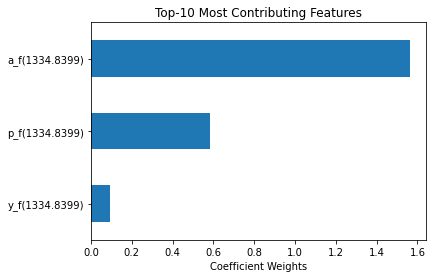

In [23]:
best_idx = 44
best_ofa = storage_df.iloc[ best_idx ][ 'model' ]

performance_report(
    classifier = best_ofa,
    X_train = X_train[ best_ofa.feature_names_in_ ],
    X_test = X_test[ best_ofa.feature_names_in_ ]
)